<a name="top" id="top"></a>

<div align="center">
    <h1>Introduction to Mathematical Programming</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <br>
    <a href="https://github.com/murraybj">Benjamin J. L. Murray</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Undergraduate Research Assistant</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/QUBONotebooks/blob/main/notebooks_py/5-Benchmarking_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

## Introduction to Mathematical Programming
### Modeling
The solution of optimization problems requires the development of a mathematical model. Here we will model an example given in the lecture and see how an integer program can be solved practically. This example will use as modeling language **[Pyomo](http://www.pyomo.org/)**, an open-source Python package, which provides a flexible access to different solvers and a general modeling framework for linear and nonlinear integer programs.
The examples solved here will make use of open-source solvers **[GLPK](https://www.gnu.org/software/glpk/)** and **[CLP/CBC](https://projects.coin-or.org/Cbc)** for linear and mixed-integer linear programming, **[IPOPT](https://coin-or.github.io/Ipopt/)** for interior point (non)linear programming, **[BONMIN](https://www.coin-or.org/Bonmin/)** for convex integer nonlinear programming and **[COUENNE](https://projects.coin-or.org/Couenne)** for nonconvex (global) integer nonlinear programming.

In [1]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's start with Pyomo
if IN_COLAB:
    !pip install -q pyomo


In [2]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
import sys
import os

#### Problem statement

Suppose there is a company that produces two different products, A and B, which can be sold at different values, $\$5.5$ and $\$2.1$ per unit, respectively.
The company only counts with a single machine with electricity usage of at most 17kW/day. Producing each A and B consumes $8\text{kW}/\text{day}$ and $2\text{kW}/\text{day}$, respectively.
Besides, the company can only produce at most $2$ more units of B than A per day.

### Linear Programming
This is a valid model, but it would be easier to solve if we had a mathematical representation.
Assuming the units produced of A are $x_1$ and of B are $x_2$ we have

$$
\begin{array}{rl}
    \displaystyle%
    \max_{x_1, x_2} & 5.5x_1 + 2.1x_2 \\
    \textrm{s.t.}   & x_2 \le x_1 + 2 \\
                    & 8x_1 + 2x_2 \le 17 \\
                    & x_1, x_2 \ge 0
\end{array}
$$

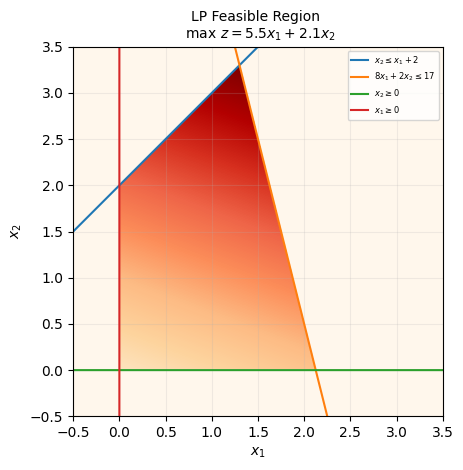

In [3]:
# Generate the feasible region plot of this problem

# Define meshgrid for feasible region
d = np.linspace(-0.5,3.5,300)
x1,x2 = np.meshgrid(d,d)

# Define the lines for the constraints
x = np.linspace(x1.min(), x1.max(), 2000)
# x2 <= x1 + 2
x21 = x + 2
# 8*x1 + 2*x2 <= 17
x22 = (17-8*x)/2.0
# obj: min 7.3x1 + 2.1x2
Z = 5.5*x1 + 2.1*x2

# generate heatmap from objective function
objective_heatmap = np.fromfunction(lambda i, j:5.5 * i + 2.1 * j,(300,300), dtype=float)

# Plot feasible region
fig, ax = plt.subplots()
feas_reg = ax.imshow( (
    (x1>=0) &           # Bound 1 
    (x2>=0) &           # Bound 2
    (x2 <= x1 + 2) &    # Constraint 1
    (8*x1 + 2*x2 <= 17) # Constraint 2
    ).astype(int) 
    * objective_heatmap, # objective function
                extent=(x1.min(),x1.max(),x2.min(),x2.max()),origin="lower", cmap="OrRd", alpha = 1)

# Make plots of constraints
ax.plot(x, x21, label=r'$x_2 \leq x_1 + 2$')
ax.plot(x, x22, label=r'$8x_1 + 2x_2 \leq 17$')

# Nonnegativitivy constraints
plt.plot(x, np.zeros_like(x), label=r'$x_2 \geq 0$')
plt.plot(np.zeros_like(x), x, label=r'$x_1 \geq 0$')

# plot formatting
plt.title("LP Feasible Region \n max $z = 5.5x_{1} + 2.1x_{2}$",fontsize=10,y=1)
plt.xlim(x1.min(),x1.max())
plt.ylim(x2.min(),x2.max())
plt.legend(loc='upper right', prop={'size': 6})
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.grid(alpha=0.2)


In [4]:
# Define the model
model = pyo.ConcreteModel(name='Simple example LP')
# Define the variables
model.x = pyo.Var([1,2], domain=pyo.NonNegativeReals)
# Define the objective function
def _obj(m):
    return 5.5*m.x[1] + 2.1*m.x[2]

model.obj = pyo.Objective(rule = _obj, sense=pyo.maximize)
# Define the constraints
def _constraint1(m):
    return m.x[2] <= m.x[1] + 2

def _constraint2(m):
    return 8*m.x[1] + 2*m.x[2] <= 17
    
model.Constraint1 = pyo.Constraint(rule = _constraint1)

model.Constraint2 = pyo.Constraint(rule = _constraint2)
# Print the model
model.pprint()

1 Var Declarations
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :  None : False :  True : NonNegativeReals
          2 :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 5.5*x[1] + 2.1*x[2]

2 Constraint Declarations
    Constraint1 : Size=1, Index=None, Active=True
        Key  : Lower : Body              : Upper : Active
        None :  -Inf : x[2] - (x[1] + 2) :   0.0 :   True
    Constraint2 : Size=1, Index=None, Active=True
        Key  : Lower : Body            : Upper : Active
        None :  -Inf : 8*x[1] + 2*x[2] :  17.0 :   True

4 Declarations: x obj Constraint1 Constraint2


In [5]:
# Let's install the LP/MIP solvers GLPK and CBC
if IN_COLAB:
    !apt-get install -y -qq glpk-utils
    !apt-get install -y -qq coinor-cbc
    

In [6]:
# Define the solvers GLPK and CBC
if IN_COLAB:
    opt_glpk = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol')
    opt_cbc = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
else:
    opt_glpk = pyo.SolverFactory('glpk')
    opt_cbc = pyo.SolverFactory('cbc')
# Here we could use another solver, e.g. gurobi or cplex
# opt_gurobi = pyo.SolverFactory('gurobi')

In [7]:
# Here we solve the optimization problem, the option tee=True prints the solver output
result_obj = opt_glpk.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpwrdhqw9n.glpk.raw --wglp /tmp/tmp4auuhham.glpk.glp --cpxlp
 /tmp/tmp6tbj3n1k.pyomo.lp
Reading problem data from '/tmp/tmp6tbj3n1k.pyomo.lp'...
2 rows, 2 columns, 4 non-zeros
23 lines were read
Writing problem data to '/tmp/tmp4auuhham.glpk.glp'...
15 lines were written
GLPK Simplex Optimizer 5.0
2 rows, 2 columns, 4 non-zeros
Preprocessing...
2 rows, 2 columns, 4 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  8.000e+00  ratio =  8.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 2
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (2)
*     2: obj =   1.408000000e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (39693 bytes)
Writing basic solution to '/tmp/tmpwrdhqw9n.glpk.raw'...
13 lines were written


In [8]:
# Display solution of the problem
model.display()

Model Simple example LP

  Variables:
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :   1.3 :  None : False : False : NonNegativeReals
          2 :     0 :   3.3 :  None : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 14.08

  Constraints:
    Constraint1 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  0.0 :   0.0
    Constraint2 : Size=1
        Key  : Lower : Body : Upper
        None :  None : 17.0 :  17.0


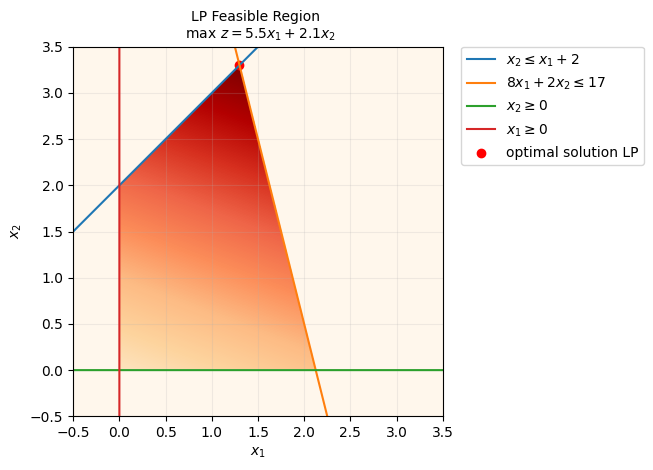

In [9]:
# Optimal solution LP
ax.scatter(1.3,3.3,color='r', label='optimal solution LP')
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()
fig

We observe that the optimal solution of this problem is $x_1 = 1.3$, $x_2 = 3.3$, leading to a profit of $14.08$.

In [10]:
# We obtain the same solution with CBC
result_obj = opt_cbc.solve(model, tee=False)
model.display()

Model Simple example LP

  Variables:
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :   1.3 :  None : False : False : NonNegativeReals
          2 :     0 :   3.3 :  None : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 14.08

  Constraints:
    Constraint1 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  0.0 :   0.0
    Constraint2 : Size=1
        Key  : Lower : Body : Upper
        None :  None : 17.0 :  17.0


The solvers GLPK and CLP implement the simplex method (with many improvements) by default but we can also use an interior point method thorugh the solver IPOPT (interior point optimizer). IPOPT is able to not only solve linear but also nonlinear problems.

In [11]:
# Define the solver IPOPT
if IN_COLAB:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./solvers
    os.environ['PATH'] += ':solvers'
    opt_ipopt = pyo.SolverFactory('ipopt', executable='/content/solvers/ipopt')
else:
    opt_ipopt = pyo.SolverFactory('ipopt')

In [12]:
# Here we solve the optimization problem, the option tee=True prints the solver output
result_obj_ipopt = opt_ipopt.solve(model, tee=True)
model.display()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

We obtain the same result as previously, but notice that the interior point method reports some solution subject to certain tolerance, given by its convergence properties when it can get infinitesimally close (but not directly at) the boundary of the feasible region.

### Integer Programming
Now let's consider that only integer units of each product can be produced, namely
$$
\max_{x_1, x_2} 5.5x_1 + 2.1x_2 \\
s.t. x_2 \leq x_1 + 2 \\
8x_1 + 2x_2 \leq 17 \\
x_1, x_2 \geq 0 \\
x_1, x_2 \in \mathbb{Z}
$$

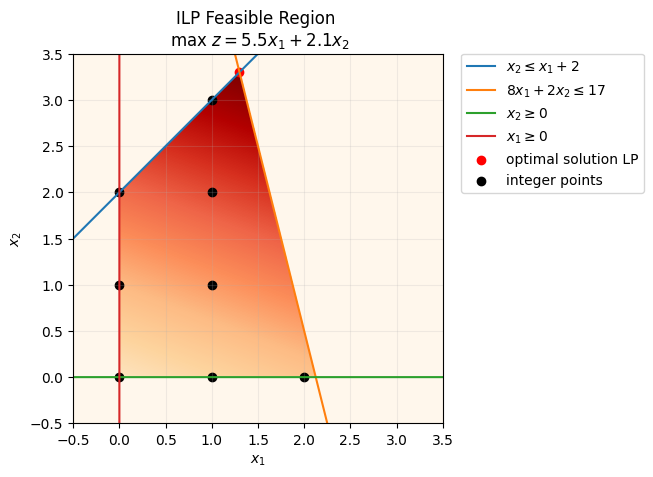

In [13]:
# Define grid for integer points
x1_int, x2_int = np.meshgrid(range(math.ceil(x1.max())), range(math.ceil(x2.max())))
idx = ((x1_int>=0) & (x2_int <= x1_int + 2) & (8*x1_int + 2*x2_int <= 17) & (x2_int>=0))
x1_int, x2_int = x1_int[idx], x2_int[idx]
ax.scatter(x1_int,x2_int,color='k', label='integer points')

# Plotting optimal solution IP
# plt.title("LP Feasible Region \n max $z = 5.5x_{1} + 2.1x_{2}$",fontsize=10,y=1)
ax.set_title("ILP Feasible Region \n max $z = 5.5x_{1} + 2.1x_{2}$")
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()
fig

In [14]:
# Define the integer model
model_ilp = pyo.ConcreteModel(name='Simple example IP, 47-779 QuIP')
#Define the variables
model_ilp.x = pyo.Var([1,2], domain=pyo.Integers)
# Define the objective function
model_ilp.obj = pyo.Objective(rule = _obj, sense=pyo.maximize)
# Define the constraints
model_ilp.Constraint1 = pyo.Constraint(rule = _constraint1)

model_ilp.Constraint2 = pyo.Constraint(rule = _constraint2)
# Print the model
model_ilp.pprint()

1 Var Declarations
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :  None :  None : False :  True : Integers
          2 :  None :  None :  None : False :  True : Integers

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 5.5*x[1] + 2.1*x[2]

2 Constraint Declarations
    Constraint1 : Size=1, Index=None, Active=True
        Key  : Lower : Body              : Upper : Active
        None :  -Inf : x[2] - (x[1] + 2) :   0.0 :   True
    Constraint2 : Size=1, Index=None, Active=True
        Key  : Lower : Body            : Upper : Active
        None :  -Inf : 8*x[1] + 2*x[2] :  17.0 :   True

4 Declarations: x obj Constraint1 Constraint2


In [15]:
# Here we solve the optimization problem, the option tee=True prints the solver output
result_obj_ilp = opt_cbc.solve(model_ilp, tee=False)

In [16]:
model_ilp.display()

Model 'Simple example IP, 47-779 QuIP'

  Variables:
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :   1.0 :  None : False : False : Integers
          2 :  None :   3.0 :  None : False : False : Integers

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :  11.8

  Constraints:
    Constraint1 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  0.0 :   0.0
    Constraint2 : Size=1
        Key  : Lower : Body : Upper
        None :  None : 14.0 :  17.0


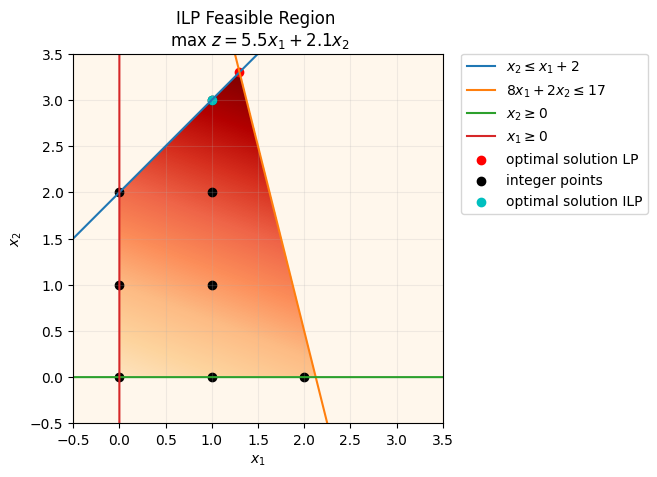

In [17]:
# Optimal solution ILP
ax.scatter(1,3,color='c', label='optimal solution ILP')
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()
fig

Here the solution becomes $x_1 = 1, x_2 = 3$ with an objective of $11.8$.

#### Enumeration
Enumerating all the possible solutions in this problem might be very efficient (there are only 8 feasible solutions), this this we only know from the plot. Assuming that the upper bounds for variables was instead 4, the possible solutions would then be 16. With a larger number of variables the enumeration turns to be impractical. For $n$ binary variables (we can always "binarize" the integer variables) the number of possible solutions is $2^n$.

In many other applications, the possible solutions come from permutations of the integer variables (e.g. assignment problems), which grow as $n!$ with the size of the input.

This growth makes the problem grow out of control fairly quickly.

Text(0, 0.5, 'Possible solutions')

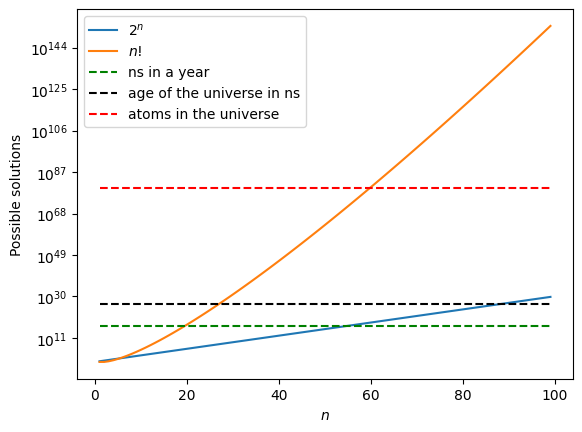

In [18]:
fig2, ax2 = plt.subplots()
n = np.arange(1,100,1)
ax2.plot(n,np.exp(n*np.log(2)), label=r'$2^n$')
ax2.plot(n,gamma(n), label=r'$n!$')

ax2.plot(n,3.154E16*np.ones_like(n), 'g--', label=r'ns in a year')
ax2.plot(n,4.3E26*np.ones_like(n), 'k--', label=r'age of the universe in ns')
ax2.plot(n,6E79*np.ones_like(n), 'r--', label=r'atoms in the universe')
plt.yscale('log')

plt.legend()
plt.xlabel(r'$n$')
plt.ylabel('Possible solutions')

### Integer convex nonlinear programming
The following constraint "the production of B minus 1 squared can only be smaller than 2 minus the production of A" can be incorporated  in the following convex integer nonlinear program
$$
\max_{x_1, x_2} 5.5x_1 + 2.1x_2 \\
s.t. x_2 \leq x_1 + 2 \\
8x_1 + 2x_2 \leq 17 \\
(x_2-1)^2 \leq 2-x_1\\
x_1, x_2 \geq 0 \\
x_1, x_2 \in \mathbb{Z}
$$

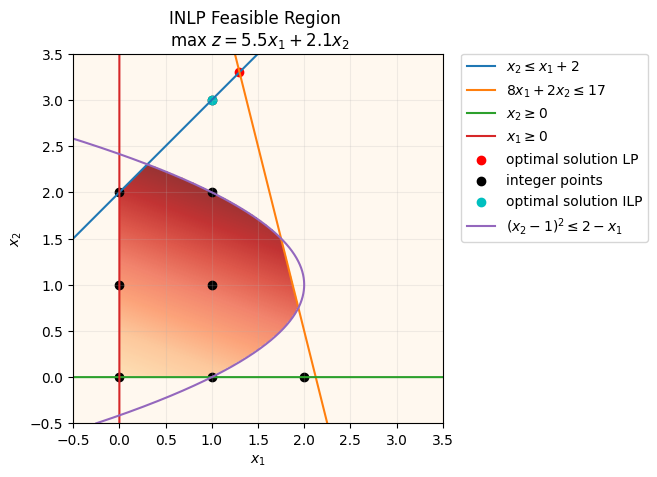

In [19]:
# Define grid for integer points
feas_reg.remove()
feas_reg = ax.imshow( (
    (x1>=0) &           # Bound 1 
    (x2>=0) &           # Bound 2
    (x2 <= x1 + 2) &    # Constraint 1
    (8*x1 + 2*x2 <= 17) & # Constraint 2
    ((x2-1)**2 <= 2-x1) # Nonlinear constraint
    ).astype(int) 
    * objective_heatmap, # objective function, 
                extent=(x1.min(),x1.max(),x2.min(),x2.max()),origin="lower", cmap="OrRd", alpha = .8)


x1nl = 2- (x - 1)**2
# Nonlinear constraint
nl_const = ax.plot(x1nl, x, label=r'$(x_2-1)^2 \leq 2-x_1$')

# Plotting optimal solution INLP
ax.set_title("INLP Feasible Region \n max $z = 5.5x_{1} + 2.1x_{2}$")
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()
fig

In [20]:
# Define the integer model
model_cinlp = pyo.ConcreteModel(name='Simple example convex INLP, 47-779 QuIP')
#Define the variables
model_cinlp.x = pyo.Var([1,2], domain=pyo.Integers)
# Define the objective function
model_cinlp.obj = pyo.Objective(rule = _obj, sense=pyo.maximize)
# Define the constraints
model_cinlp.Constraint1 = pyo.Constraint(rule = _constraint1)

model_cinlp.Constraint2 = pyo.Constraint(rule = _constraint2)

model_cinlp.Constraint3 = pyo.Constraint(expr = (model_cinlp.x[2]-1)**2 <= 2 - model_cinlp.x[1])


# Print the model
model_cinlp.pprint()

1 Var Declarations
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :  None :  None : False :  True : Integers
          2 :  None :  None :  None : False :  True : Integers

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 5.5*x[1] + 2.1*x[2]

3 Constraint Declarations
    Constraint1 : Size=1, Index=None, Active=True
        Key  : Lower : Body              : Upper : Active
        None :  -Inf : x[2] - (x[1] + 2) :   0.0 :   True
    Constraint2 : Size=1, Index=None, Active=True
        Key  : Lower : Body            : Upper : Active
        None :  -Inf : 8*x[1] + 2*x[2] :  17.0 :   True
    Constraint3 : Size=1, Index=None, Active=True
        Key  : Lower : Body                       : Upper : Active
        None :  -Inf : (x[2] - 1)**2 - (2 - x[1]) :   0.0 :   True

5 Declarations: x obj Constraint1 Constraint2 Constraint

In [21]:
# Define the solver BONMIN
if IN_COLAB:
    opt_bonmin = pyo.SolverFactory('bonmin', executable='/content/solvers/bonmin')
else:
    opt_bonmin = pyo.SolverFactory('bonmin')

In [22]:
# Here we solve the optimization problem, the option tee=True prints the solver output
result_obj_cinlp = opt_bonmin.solve(model_cinlp, tee=False)
model_cinlp.display()

Model 'Simple example convex INLP, 47-779 QuIP'

  Variables:
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :   1.0 :  None : False : False : Integers
          2 :  None :   2.0 :  None : False : False : Integers

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   9.7

  Constraints:
    Constraint1 : Size=1
        Key  : Lower : Body : Upper
        None :  None : -1.0 :   0.0
    Constraint2 : Size=1
        Key  : Lower : Body : Upper
        None :  None : 12.0 :  17.0
    Constraint3 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  0.0 :   0.0


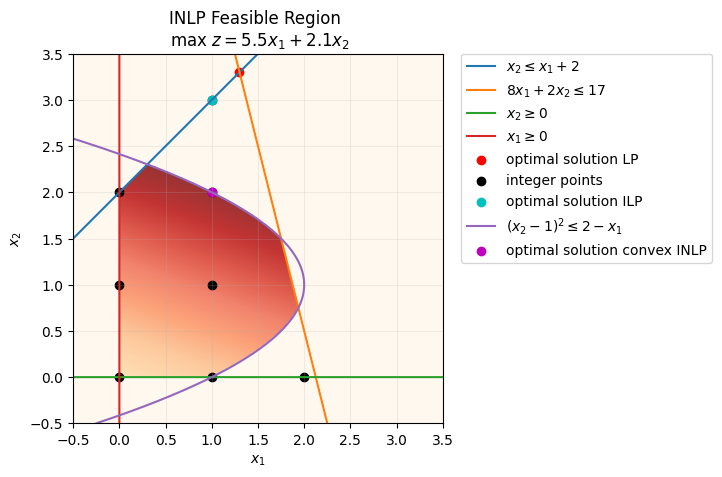

In [23]:
ax.scatter(1,2,color='m', label='optimal solution convex INLP')
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()
fig

In this case the optimal solution becomes $x_1 = 1, x_2 = 2$ with an objective of $9.7$.

### Integer non-convex programming
The last constraint "the production of B minus 1 squared can only be greater than the production of A plus one half" can be incorporated  in the following convex integer nonlinear program
$$
\max_{x_1, x_2} 5.5x_1 + 2.1x_2 \\
s.t. x_2 \leq x_1 + 2 \\
8x_1 + 2x_2 \leq 17 \\
(x_2-1)^2 \leq 2-x_1\\
(x_2-1)^2 \geq 1/2+x_1\\
x_1, x_2 \geq 0 \\
x_1, x_2 \in \mathbb{Z}
$$

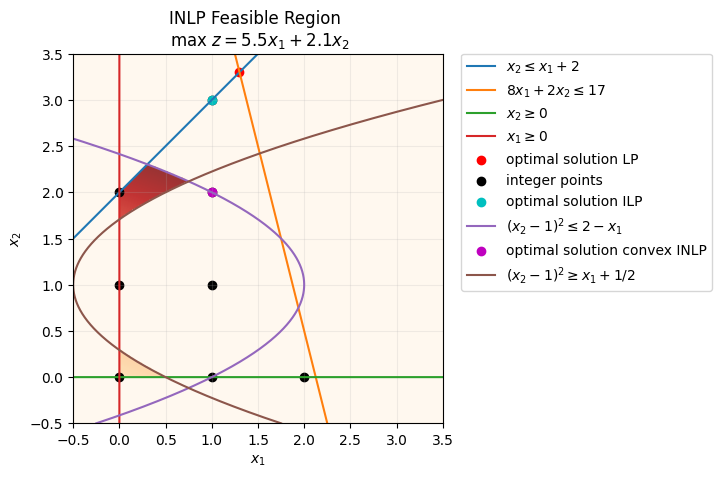

In [24]:
# Define grid for integer points
feas_reg.remove()
feas_reg = ax.imshow( (
    (x1>=0) &           # Bound 1 
    (x2>=0) &           # Bound 2
    (x2 <= x1 + 2) &    # Constraint 1
    (8*x1 + 2*x2 <= 17) & # Constraint 2
    ((x2-1)**2 <= 2-x1) & # Nonlinear constraint 1
    ((x2-1)**2 >= x1+0.5) # Nonlinear constraint 2
    ).astype(int) 
    * objective_heatmap,  # objective function,
                extent=(x1.min(),x1.max(),x2.min(),x2.max()),origin="lower", cmap="OrRd", alpha = .8)


x1nl = -1/2 + (x - 1)**2
# Nonlinear constraint
nl_const = ax.plot(x1nl, x, label=r'$(x_2-1)^2 \geq x_1 + 1/2$')

ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()
fig

In [25]:
# Define the integer model
model_ncinlp = pyo.ConcreteModel(name='Simple example non-convex INP, 47-779 QuIP')
#Define the variables
model_ncinlp.x = pyo.Var([1,2], domain=pyo.Integers)
# Define the objective function
model_ncinlp.obj = pyo.Objective(rule = _obj, sense=pyo.maximize)
# Define the constraints
model_ncinlp.Constraint1 = pyo.Constraint(rule = _constraint1)

model_ncinlp.Constraint2 = pyo.Constraint(rule = _constraint2)

model_ncinlp.Constraint3 = pyo.Constraint(expr = (model_ncinlp.x[2]-1)**2 <= 2 - model_ncinlp.x[1])

model_ncinlp.Constraint4 = pyo.Constraint(expr = (model_ncinlp.x[2]-1)**2 >= 1/2 + model_ncinlp.x[1])


# Print the model
model_ncinlp.pprint()

1 Var Declarations
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :  None :  None : False :  True : Integers
          2 :  None :  None :  None : False :  True : Integers

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 5.5*x[1] + 2.1*x[2]

4 Constraint Declarations
    Constraint1 : Size=1, Index=None, Active=True
        Key  : Lower : Body              : Upper : Active
        None :  -Inf : x[2] - (x[1] + 2) :   0.0 :   True
    Constraint2 : Size=1, Index=None, Active=True
        Key  : Lower : Body            : Upper : Active
        None :  -Inf : 8*x[1] + 2*x[2] :  17.0 :   True
    Constraint3 : Size=1, Index=None, Active=True
        Key  : Lower : Body                       : Upper : Active
        None :  -Inf : (x[2] - 1)**2 - (2 - x[1]) :   0.0 :   True
    Constraint4 : Size=1, Index=None, Active=True
       

In [26]:
# Trying to solve the problem with BONMIN we might obtain the optimal solution, but we have no guarantees
result_obj_ncinlp = opt_bonmin.solve(model_ncinlp, tee=False)
model_ncinlp.display()

Model 'Simple example non-convex INP, 47-779 QuIP'

  Variables:
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :   0.0 :  None : False : False : Integers
          2 :  None :   2.0 :  None : False : False : Integers

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   4.2

  Constraints:
    Constraint1 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  0.0 :   0.0
    Constraint2 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  4.0 :  17.0
    Constraint3 : Size=1
        Key  : Lower : Body : Upper
        None :  None : -1.0 :   0.0
    Constraint4 : Size=1
        Key  : Lower : Body : Upper
        None :  None : -0.5 :   0.0


In [27]:
# Define the solver COUENNE
if IN_COLAB:
    opt_couenne = pyo.SolverFactory('couenne', executable='/content/solvers/couenne')
else:
    opt_couenne = pyo.SolverFactory('couenne')

In [28]:
# Trying to solve the problem with global MINLP solver COUENNE
result_obj_ncinlp = opt_couenne.solve(model_ncinlp, tee=False)
model_ncinlp.display()

Model 'Simple example non-convex INP, 47-779 QuIP'

  Variables:
    x : Size=2, Index={1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :   0.0 :  None : False : False : Integers
          2 :  None :   2.0 :  None : False : False : Integers

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   4.2

  Constraints:
    Constraint1 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  0.0 :   0.0
    Constraint2 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  4.0 :  17.0
    Constraint3 : Size=1
        Key  : Lower : Body : Upper
        None :  None : -1.0 :   0.0
    Constraint4 : Size=1
        Key  : Lower : Body : Upper
        None :  None : -0.5 :   0.0


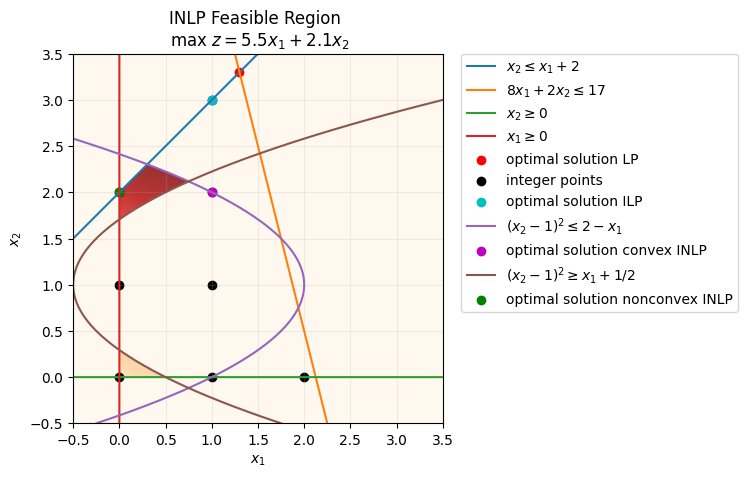

In [29]:
ax.scatter(0,2,color='g', label='optimal solution nonconvex INLP')
ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()
fig

We are able to solve non-convex MINLP problems but the complexity of this problems leads to great challenges that need to be overcomed.

### Powerful commercial solver installation

#### Gurobi Installation
Gurobi is one of the most powerful LP and MIP solvers available today. They provide free academic licences. In order to install the software visit their **[Website](https://www.gurobi.com/)**, create an account, and obtain a license. Once you do that you can download and use the software.

#### BARON Installation
BARON is one of the most powerful MINLP solvers available today.  In order to install the software visit their **[Website](https://www.minlp.com/home)**, create an account, and obtain a license. Once you do that you can download and use the software.